In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
import warnings
warnings.filterwarnings('once')

In [2]:
df_total = pd.read_pickle('../../../datos_finales/archivo_total_est_enc2.pkl')
df_total.head(2)

,estacion,año,mes,dia_semana,dias_laborables,tiempo,temperatura,humedad,velocidad_viento,total_usuarios
0,1.0,1.0,1.0,1.04,1.00,2.23,-0.486274,0.855582,-0.208909,985
1,1.0,1.0,1.0,1.01,1.05,2.23,-0.425690,0.332722,0.687550,801


### Modelo sin especificar hiperparámetros

In [3]:
X = df_total.drop("total_usuarios", axis = 1)
y = df_total["total_usuarios"]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
arbol = DecisionTreeRegressor(random_state =0)
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

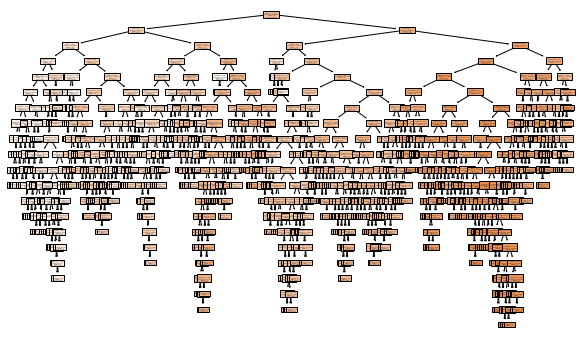

In [6]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = list(x_train.columns), filled = True)
plt.show()

In [7]:
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [8]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """
    Esta función nos dice las métricas de nuestro modelo.
    Args:
        y_test (Serie): el test de nuestra variable respuesta.
        y_train (Serie): el train de nuestra variable respuesta.
        y_test_pred (Serie): la predicción para el test de nuestra variable respuesta.
        y_train_pred (Serie): la predicción para el train de nuestra variable respuesta.
        tipo_modelo (str): nombre que le damos al modelo.
    Returns:
        dataframe con todas las métricas de nuestro modelo.
    """
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [9]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,513.753425,448087.232877,669.393183,0.869089,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I


Como podemos comprobar, tenemos overfitting porque el R2 es 1 y el resto de las métricas es 0. Además, hay mucha diferencia entre el train y el test, por lo que vamos a reducir la profundidad del modelo.

### Especificamos los hiperparámetros

In [10]:
print(arbol.tree_.max_depth)

20


In [11]:
max_features = np.sqrt(len(x_train.columns))
max_features

3.0

In [12]:
param = {"max_depth": [4,6,8], # tiene 19 de profundidad y como hay overfitting lo reducimos a la mitad.
        "max_features": [1,2,3], # como la raíz cuadrada es 3, llegamos hasta 3.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [10,25,50], 
        "min_samples_leaf": [10,25,50]} 

In [13]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [14]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 25, 50],
                         'min_samples_split': [10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [15]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

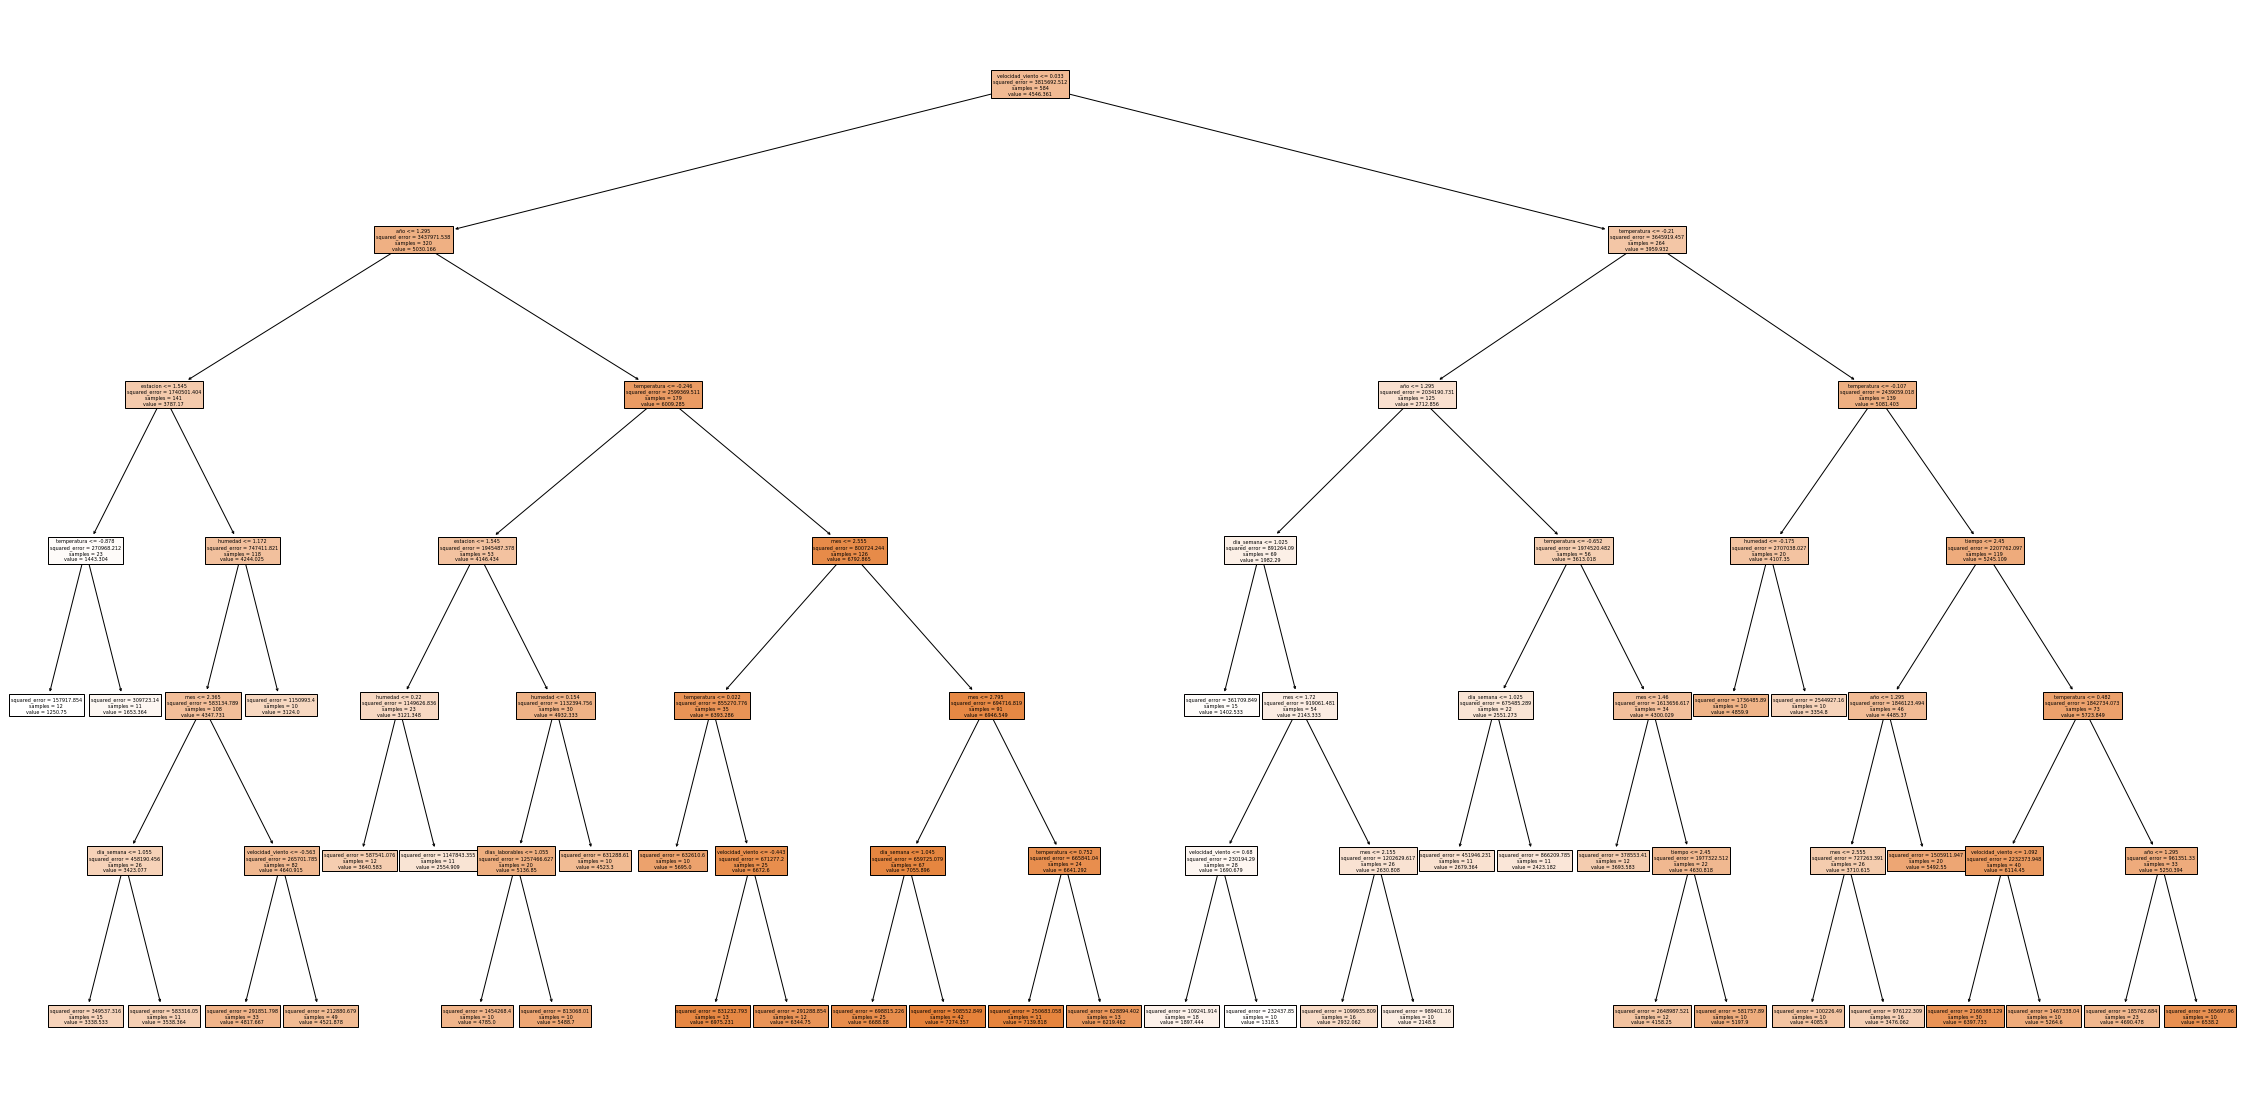

In [16]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=list(x_train.columns), filled=True);

In [17]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [18]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,729.866667,932447.989189,965.633465,0.727581,test,Decision tree II
1,639.774356,751012.585211,866.609823,0.803178,train,Decision tree II


### Conclusiones

Podemos decir que las métricas obtenidas son bastante buenas porque R2 es mayor que 0.7 y hay un poco de diferencia en el RMSE y MSE entre el train y el test. Por lo tanto, hay un poco de overfitting.

In [19]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,temperatura,0.402186
1,año,0.296879
0,estacion,0.108216
8,velocidad_viento,0.101511
2,mes,0.036235
5,tiempo,0.027477
7,humedad,0.019168
3,dia_semana,0.006944
4,dias_laborables,0.001383
